In [1]:
# Update PATH environment variable
import os
os.environ['PATH'] = '/opt/homebrew/bin:' + os.environ['PATH']

import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from pathlib import Path
import cosmoplots

from scipy.optimize import minimize
from scipy.special import gamma

from fppanalysis.running_moments import window_radius, run_norm_ds, run_norm
from fppanalysis.correlation_function import corr_fun
from fppanalysis.distributions import distribution, get_hist
from closedexpressions import distributions

from analysis_functions.constants import greenwald_fraction, shot_time_window
from analysis_functions.functions import psd_eq, error_func_psd, find_closest_value
from analysis_functions.apd_functions import get_signal, get_time, get_rz, get_dt

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


### This code plots the probability density function and computes its fit to a Gamma dist

In [2]:
def edit_norm_shot_noise_dist(X, g, cdf=False):
    """
    Returns the pdf or cdf of a normalized gamma distributed variable.
    If x is gamma distributed, X=(x-<x>)/x_rms
    Input:
        X: Variable values, 1d numpy array
        g: shape parameter
        cdf: toggles pdf(default) or cdf.
    Output:
        F: The pdf or cdf of X.
    """
    F = np.zeros(len(X))
    assert g > 0
    if not cdf:
        f = (
            lambda x, g: g ** (g * 0.5)
            * (x + g ** (0.5)) ** (g - 1)
            * np.exp(-(g ** (0.5)) * x - g)
            / gamma(g)
        )
    else:
        f = None
    for i in range(len(X)):
        if X[i] > -(g ** (1 / 2)):
            F[i] = f(X[i], g)
    return F

# Curve fit with minimize function without additive noise
def analytic_function(params):
    """Returns logarithmic values of the pdf of a normalized gamma distributed process with additive noise
    X: Variable values
    g: shape parameter (gamma)
    e: noise parameter, e=y_rms^2 / z_rms^2.
    """
    g = params**2
    x = X[left:-right]
    # print(g)
    # return np.exp(x/(tau*lam))*np.heaviside(-x, 0.5) + np.exp(-x/((1-lam)*tau))*np.heaviside(x, 0.5)
    return (
        np.sum(
            np.abs(
                np.log(edit_norm_shot_noise_dist(x, g)) - np.log(pdf[left:-right])
            )
        )
        ** 2
    ) / np.sum(np.abs(np.log(edit_norm_shot_noise_dist(x, g))) ** 2)


def error_func_pdf(params, x, y_arr):
    y = np.log10(y_arr)
    g = params
    return np.sum((analytic_function([i], g) - y[idx]) ** 2 for idx, i in enumerate(x))




In [3]:
def generate_shots_dict(additive_noise=True):
    x0_value = [np.sqrt(50), np.sqrt(0.0005)] if additive_noise else [np.sqrt(50)]

    shots_pdf_fit_dict = {
        1110201016: {'left': 2, 'right': 9, 'x0': x0_value, 'bounds': ((1e-3, 200), (1e-3, 1))},
        1110201011: {'left': 3, 'right': 15, 'x0': x0_value, 'bounds': ((1e-3, 200), (1e-3, 1))},
        1160616018: {'left': 2, 'right': 5, 'x0': x0_value, 'bounds': ((1e-3, 200), (1e-3, 1))},
    }
    shots_pdf_fit_dict_additive_noise = {
        1110201016: {'left': 4, 'right': 15, 'x0': x0_value, 'bounds': ((1e-3, 200), (1e-3, 1))},
        1110201011: {'left': 4, 'right': 15, 'x0': x0_value, 'bounds': ((1e-3, 200), (1e-3, 1))},
        1160616018: {'left': 5, 'right': 12, 'x0': x0_value, 'bounds': ((1e-3, 200), (1e-3, 1))},
    }

    return shots_pdf_fit_dict_additive_noise if additive_noise else shots_pdf_fit_dict

In [4]:
shotlist = [1110201016, 1110201011, 1160616018]
f_GWs = [greenwald_fraction[shot] for shot in shotlist]
marker_list = ['^', 'o', 'v']
color_list = ['#785EF0', '#DC267F', '#FFB000']
label_name = ['EDA H', 'ELM-free H', 'Ohmic']

In [7]:
def analytic_function(params, X, pdf, left, right):
    """Returns logarithmic values of the pdf of a normalized gamma distributed process with additive noise."""
    g = params**2
    x = X[left:-right]
    return (
        np.sum(
            np.abs(
                np.log(edit_norm_shot_noise_dist(x, g)) - np.log(pdf[left:-right])
            )
        )
        ** 2
    ) / np.sum(np.abs(np.log(edit_norm_shot_noise_dist(x, g))) ** 2)

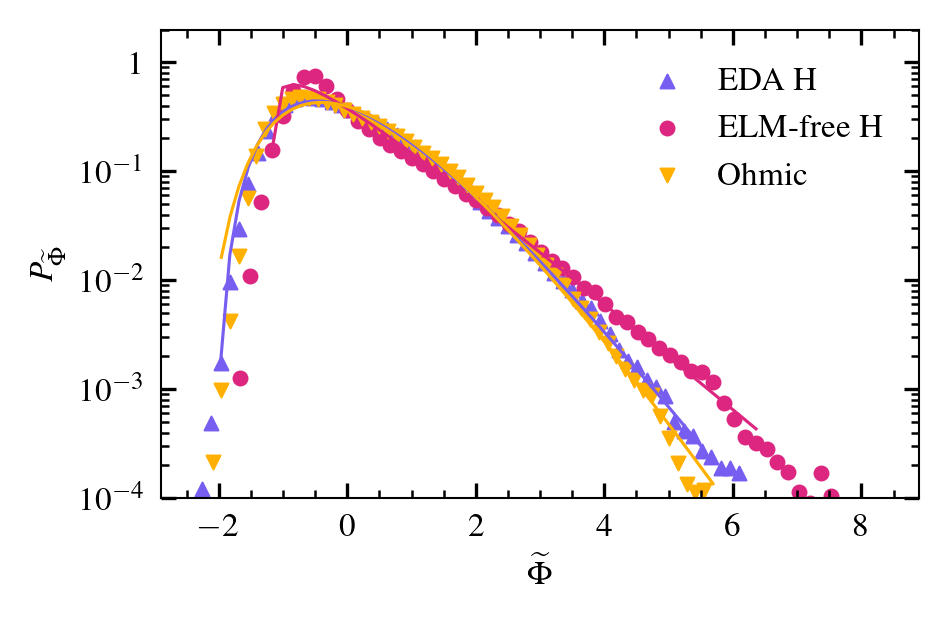

In [14]:
save = True

params = {}
cosmoplots.set_rcparams_dynamo(params, num_cols=1)
plt.style.use(["cosmoplots.default"])
plt.rcParams['text.latex.preamble'] =  r'\usepackage{amsmath}' r'\usepackage{times}' r'\usepackage{mathptmx}' r'\usepackage{amssymb}' r'\newcommand{\taup}{\ensuremath{\tau_\shortparallel}}' r'\newcommand{\wh}{\widehat}' r'\newcommand{\ave}[1]{{\left<#1\right>}}'
plt.rc('font',family='Times New Roman')

fig, ax = plt.subplots()

y_pixel = 4
x_pixel = 7

for idx, shot in enumerate(shotlist):
    path = Path("/Users/ahe104/Box/mfe_data/raw_apd_data")
    ds = xr.open_dataset(path / f"apd_signal_array_{shot}.nc")
    
    # Remove dead pixels
    path_dead_pixel = Path('/Users/ahe104/Box/mfe_data/dead_pixels')
    dead_pix = np.load(path_dead_pixel / f"dead_pixels_shot_{shot}.npz")
    dead_pix_arr = dead_pix['dead_pix_arr']
    dead_pix_arr_ds = dead_pix_arr[::-1, :]  # Flip array to match ds['frames'] orientation
    for y in range(dead_pix_arr_ds.shape[0]):
        for x in range(dead_pix_arr_ds.shape[1]):
            if dead_pix_arr_ds[9-y, x]:
                ds['frames'].loc[dict(y=y, x=x)] = np.nan
    t_start, t_end = shot_time_window[shot]
    ds = ds.sel(time=slice(t_start, t_end))
    data = get_signal(x=x_pixel, y=y_pixel, ds=ds)
    time = get_time(x=x_pixel, y=y_pixel, ds=ds)

    # If pixel is dead, look at pixel above and below
    if np.isnan(data).all():
        data_up = get_signal(x=x_pixel, y=y_pixel+1, ds=ds)
        time_up = get_time(x=x_pixel, y=y_pixel+1, ds=ds)
        data_down = get_signal(x=x_pixel, y=y_pixel-1, ds=ds)
        time_down = get_time(x=x_pixel, y=y_pixel-1, ds=ds)
        data = data_up + data_down
        freq = 1e3
        window = window_radius(freq, time_up)
        norm_signal, norm_time = run_norm(data, window, time_up)
        pdf_down, cdf_down, X_up = distribution(norm_signal, 64, kernel=True)
    else:
        freq = 1e3
        window = window_radius(freq, time)
        norm_signal, norm_time = run_norm(data, window, time)
        pdf, cdf, X = distribution(norm_signal, 64, kernel=True)

    R, Z = get_rz(x_pixel, y_pixel, ds)
    R_round = '{:0.2f}'.format(R)
    Z_round = '{:0.2f}'.format(Z)
    fgw = '{:0.2f}'.format(f_GWs[idx])

    # Plot
    ax.scatter(X, pdf, color=color_list[idx], label=label_name[idx], marker=marker_list[idx], s=11)

    # Fit to Gamma distribution
    pdf_fit_params_dict = generate_shots_dict(additive_noise=False)
    left = pdf_fit_params_dict[shot]['left']
    right = pdf_fit_params_dict[shot]['right']
    x0 = pdf_fit_params_dict[shot]['x0']
    bounds = pdf_fit_params_dict[shot]['bounds']

    # Curve fit with minimize function without additive noise
    res = minimize(
        analytic_function, args=(X, pdf, left, right), method="Nelder-Mead", x0=np.sqrt(50)
    )
    g_opt = res.x[0] ** 2
    g_opt_round = "{:0.2f}".format(g_opt)

    # Plot curve fit
    ax.plot(
        X[left:-right],
        distributions.norm_shot_noise_dist(X[left:-right], g_opt),
        color=color_list[idx],
    )
    #print(f"Shot {shot}, gamma: {g_opt_round}")
    
    #ax.axvline(x=X[left], color=color_list[idx], ls=':', lw=0.5)
    #ax.axvline(x=X[-right], color=color_list[idx], ls=':', lw=0.5)

ax.set_xlabel(r"$\widetilde{\Phi}$")
ax.set_ylabel(r"$P_{\widetilde{\Phi}}$")
ax.set_yscale('log')
ax.set_xlim(left=-2.9, right=8.9)
ax.set_ylim(bottom=1e-4, top=2)

cosmoplots.change_log_axis_base(ax, "y")
cosmoplots.change_log_axis_base(ax, "y")
plt.legend(frameon=False, borderaxespad=0.7)
plt.show()

foldername = '/Users/ahe104/Box/time_delay_estimation/velocity_field/analysis/PSI/'
if save == True:
    formats = ["pdf", "eps"]
    for fmt in formats:
        filename = f'apd_pdf_x_{x_pixel}_y_{y_pixel}.{fmt}'
        fig.savefig(foldername + filename, format=fmt)
